# Hydrography
-----------------
This notebook explores the hydrographic data from the glider, with a focus on asepcts that are germane to ADCP processing. These include:
- Dive average current
- Geostrophic current
- Sound speed estimates
- Depth of pycnocline and other interfaces commonly associated with velocity shear
- Water mass identification

In [1]:
import sys
import numpy as np
import pandas as pd
import xarray as xr
import copy
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
from netCDF4 import Dataset
from pathlib import Path
import gsw
import scipy.io
from datetime import datetime, timedelta
notebook_dir = !pwd # Replace with !echo %cd% if using windows
library_dir = Path(notebook_dir[0]).parent.absolute()
sys.path.append(str(library_dir))
data_raw_path = library_dir / 'data' / 'raw' / 'adcp'
glider_raw_path = library_dir / 'data' / 'raw' / 'glider'
fig_path = library_dir / 'reports' / 'figures'
from src.data.adcp_mission_analysis import read_glider_nc, edgetocentre, glidertimetoneat

style_path = library_dir / 'src' / 'visualization' / 'presentation.mplstyle'
style.use(str(style_path))


def savefig(figname, extension="png"):
    plt.savefig(
        fig_path / str(figname + "." + extension),
        format=extension,
        dpi="figure",
        bbox_inches="tight",
    )



In [3]:
#glider_df = read_glider_nc(glider_raw_path / 'sg637_var_by_var_timeseries.nc')
glider_df = read_glider_nc(Path('/media/callum/storage/Documents/sg637/2018-11-19_oban_round2/637_binned.nc'))
#glider_df = read_glider_nc(glider_raw_path / 'sg637_flag_all_timeseries.nc')

TypeError: int() argument must be a string, a bytes-like object or a number, not 'tuple'

In [29]:
glider_df

,CDOM,Chlorophyll,DAC_u,DAC_v,Scatter_650,abs_salinity,conductivity,cons_temp,depth,direction,...,sigma0,temp,roll,pitch,heading,w_H2O,glider_time,sound_speed,x,y
2020-01-28 14:13:52.867996,-0.4449,-0.0244,-0.255281,0.063666,0.000124,35.844884,56.434599,27.273904,1.040751,-1.0,...,1023.133368,27.297059,7.4,-61.5,123.4,-0.015383,2020-01-28 14:13:52.867996,1540.314215,-157761.265075,-92227.416820
2020-01-28 14:13:58.723004,-0.8898,-0.0244,-0.255281,0.063666,0.000121,35.843955,56.435153,27.275625,1.130815,-1.0,...,1023.132129,27.298762,6.0,-65.8,126.4,-0.010669,2020-01-28 14:13:58.723004,1540.318495,-157761.265075,-92227.416820
2020-01-28 14:14:05.998995,-1.3347,-0.0122,-0.255281,0.063666,0.000164,35.841873,56.443009,27.285764,1.180851,-1.0,...,1023.127326,27.308815,10.8,-64.3,109.0,-0.007623,2020-01-28 14:14:05.998995,1540.339350,-157761.265075,-92227.416820
2020-01-28 14:14:11.850995,-0.1483,-0.0244,-0.255281,0.063666,0.000124,35.845076,56.441576,27.280111,1.230887,-1.0,...,1023.131508,27.303311,25.7,-64.4,93.6,-0.006616,2020-01-28 14:14:11.850995,1540.331628,-157761.265075,-92227.416820
2020-01-28 14:14:18.099996,0.1483,-0.0122,-0.255281,0.063666,0.000124,35.843462,56.448935,27.289130,1.260909,-1.0,...,1023.127410,27.312260,2.6,-76.0,112.2,-0.004936,2020-01-28 14:14:18.099996,1540.350213,-157761.265075,-92227.416820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-16 14:02:58.416004,-0.4449,0.0366,-0.041956,0.020994,0.000088,35.615417,55.448088,26.656693,2.511714,1.0,...,1023.161756,26.671881,18.1,19.6,159.0,0.027964,2020-02-16 14:02:58.416004,1538.671685,-26.825655,80.132219
2020-02-16 14:03:04.036995,-0.7415,0.0244,-0.041956,0.020994,0.000121,35.614259,55.446285,26.657043,1.731184,1.0,...,1023.160791,26.672006,19.1,22.3,176.2,0.021869,2020-02-16 14:03:04.036995,1538.657185,-26.774543,79.164852
2020-02-16 14:03:09.878002,-0.5932,0.0488,-0.041956,0.020994,0.000139,35.616282,55.447946,26.656450,0.840577,1.0,...,1023.162471,26.671289,10.2,17.2,190.2,0.010553,2020-02-16 14:03:09.878002,1538.642532,-26.792371,78.042754
2020-02-16 14:03:17.742996,-0.8898,0.0366,-0.041956,0.020994,0.000088,35.613719,55.433780,26.646922,0.210145,1.0,...,1023.163605,26.661530,2.5,-12.2,198.4,0.035864,2020-02-16 14:03:17.742996,1538.606582,-26.819170,77.454300


Calculate sound speed

In [18]:
glider_df['sound_speed'] = gsw.sound_speed(glider_df.abs_salinity, glider_df.temp, glider_df.pressure)

Propogate salinity flags across conductivity and density

In [19]:
glider_df.salinity[glider_df.salinity<34.5] = np.nan
glider_df.salinity[glider_df.salinity>37.5] = np.nan
glider_df.abs_salinity[np.isnan(glider_df.salinity)] = np.nan
glider_df.conductivity[np.isnan(glider_df.salinity)] = np.nan
glider_df.rho[np.isnan(glider_df.salinity)] = np.nan
glider_df.sigma0[np.isnan(glider_df.salinity)] = np.nan
glider_df.sound_speed[np.isnan(glider_df.salinity)] = np.nan


/home/callum/anaconda3/envs/adcp-glider/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/callum/anaconda3/envs/adcp-glider/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/callum/anaconda3/envs/adcp-glider/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

In [20]:
np.nansum(np.isnan(glider_df.abs_salinity.values))

2413

In [21]:
origin  = [-57.338, 14.182]
deg_lat = 110649
glider_df['x'] = (glider_df.lon - origin[0]) * deg_lat * np.cos(np.deg2rad(origin[1]))
glider_df['y'] = (glider_df.lat - origin[1]) * deg_lat

In [22]:
glider_av_df = glider_df.groupby('dive', as_index=False).median()
noot = []
for dive in glider_av_df.dive:
    df = glider_df[glider_df.dive==dive]
    noot.append((df.glider_time - df.glider_time.min()).mean() + df.glider_time.min())
glider_av_df['glider_time'] = noot

In [8]:
glider_av_df.describe()

,dive,CDOM,Chlorophyll,DAC_u,DAC_v,Scatter_650,abs_salinity,conductivity,cons_temp,depth,...,profile_num,rho,salinity,salinity_nocorr,sigma0,temp,w_H2O,sound_speed,x,y
count,295.00000,295.000000,295.000000,295.000000,295.000000,295.000000,295.000000,295.000000,295.000000,295.000000,...,295.000000,295.000000,295.000000,295.000000,295.000000,295.000000,295.000000,295.000000,295.000000,295.000000
mean,148.00000,-0.703797,-0.014992,-0.072340,0.029102,0.000085,36.281711,49.031137,19.063151,222.244568,...,295.889831,1026.941860,36.110167,36.101149,1025.954862,19.155739,0.002831,1522.992998,-23712.914652,-14149.272582
std,85.30338,0.173721,0.034546,0.056356,0.073176,0.000008,0.714384,6.676824,5.810978,160.259931,...,170.721525,1.471237,0.712009,0.707855,0.800926,5.823355,0.008022,16.109969,47397.851345,28136.358254
min,1.00000,-1.038100,-0.073200,-0.255281,-0.151446,0.000069,34.863136,35.946748,7.687974,43.086652,...,2.000000,1023.329477,34.695651,34.692964,1023.159657,7.749771,-0.023692,1490.392800,-159817.277183,-92218.994250
25%,74.50000,-0.741500,-0.024400,-0.113340,-0.016562,0.000080,35.627298,44.958306,15.608564,133.375933,...,149.000000,1026.260705,35.459723,35.458181,1025.678493,15.710496,-0.003547,1514.798385,-9722.653582,-8200.357084
50%,148.00000,-0.593200,-0.012200,-0.074532,0.017449,0.000088,36.695240,52.493562,21.973660,136.028315,...,296.000000,1026.330840,36.522324,36.513212,1025.743718,22.080269,0.004719,1531.395193,-1419.193090,-1327.247750
75%,221.50000,-0.593200,0.000000,-0.032537,0.060485,0.000091,36.745485,53.023433,22.355424,261.623031,...,443.000000,1027.788523,36.572353,36.560904,1026.642413,22.462891,0.008318,1532.478583,2069.773145,1102.605204
max,295.00000,-0.444900,0.170800,0.052440,0.305849,0.000128,37.035746,56.465354,27.230087,547.913616,...,590.000000,1029.561050,36.861580,36.848393,1027.119435,27.284513,0.028810,1540.843969,5319.000317,5080.207855


In [ ]:
def glider_kongsberg_add(glider_df, kberg_dir):
    nc_paths = sorted(kberg_dir.rglob("p*.nc"))
    drift_u, drift_v, drift_e, dac_u, dac_v, dac_e = [], [], [], [], [], []
    for path in nc_paths:
        nc = xr.open_dataset(path)
        drift_u.append(nc.surface_curr_east.values)
        drift_v.append(nc.surface_curr_north.values)
        drift_e.append(nc.surface_curr_error.values)
        dac_u.append(nc.depth_avg_curr_east.values)
        dac_v.append(nc.depth_avg_curr_north.values)
        dac_e.append(nc.depth_avg_curr_error.values)
    for variable in [drift_u, drift_v, drift_e, dac_u, dac_v, dac_e]:
        glider_df[str(variable)] = variable
    return glider_df


In [ ]:
nc = xr.open_dataset( Path('/media/callum/storage/Documents/Eureka/data/glider/sg579/sg579_EUREC4A_timeseries.nc'))

In [ ]:
glider_av_df

In [ ]:
box_size = 1000
lon_edges = np.arange(-8000, 9000, box_size)
lat_edges = np.arange(-8000, 9000, box_size)
dives_in = np.empty((len(lon_edges), len(lat_edges)))
dives_in[:] = np.nan
for i in range(len(lon_edges[:-1])):
    glider_x_in = glider_av_df[np.logical_and(glider_av_df.x>lon_edges[i], glider_av_df.x<lon_edges[i+1])]
    for j in range(len(lat_edges[:-1])):
        glider_in = glider_x_in[np.logical_and(glider_x_in.y>lat_edges[j], glider_x_in.y<lat_edges[j+1])]
        dives_in[j,i] = len(glider_in)

### Geographical location of glider dives

Here we plot the locations of the glider dives. This is the average of glider lon and lat for each dive, converted to distance from the central waypoint

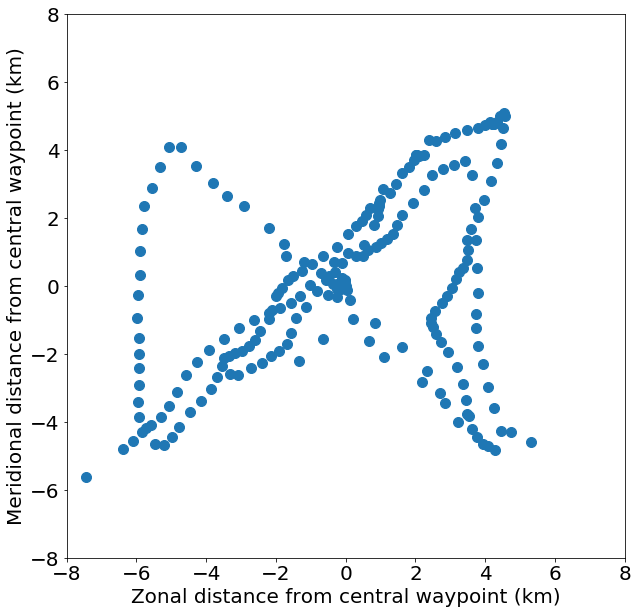

In [9]:
fig, ax = plt.subplots(figsize=[10,10])
ax.scatter(glider_av_df.x/1000, glider_av_df.y/1000)
ax.set(xlim=[-8, 8], ylim=[-8, 8], xlabel='Zonal distance from central waypoint (km)', ylabel='Meridional distance from central waypoint (km)')
savefig('dive_locations')

As above for the density of glider dives in each 1 km square box

In [ ]:
fig, ax = plt.subplots(figsize=[12,10])
c = ax.pcolor(lon_edges/1000, lat_edges/1000,dives_in, cmap='Blues')
ax.set(xlabel='Zonal distance from center (km)', ylabel='Meridional distance from center (km)')
fig.colorbar(c, ax=ax, label='Number of dives in 1km square box')
savefig('Dive_concentration')


The maximum distance between two glider dives is 15 km. At 14 degrees north of the equator in a water depth of several km, the approximation of a virtual mooring seems appropriate. 

Plotting the variation of dive average current during the deployment. These are coloured by heading. 

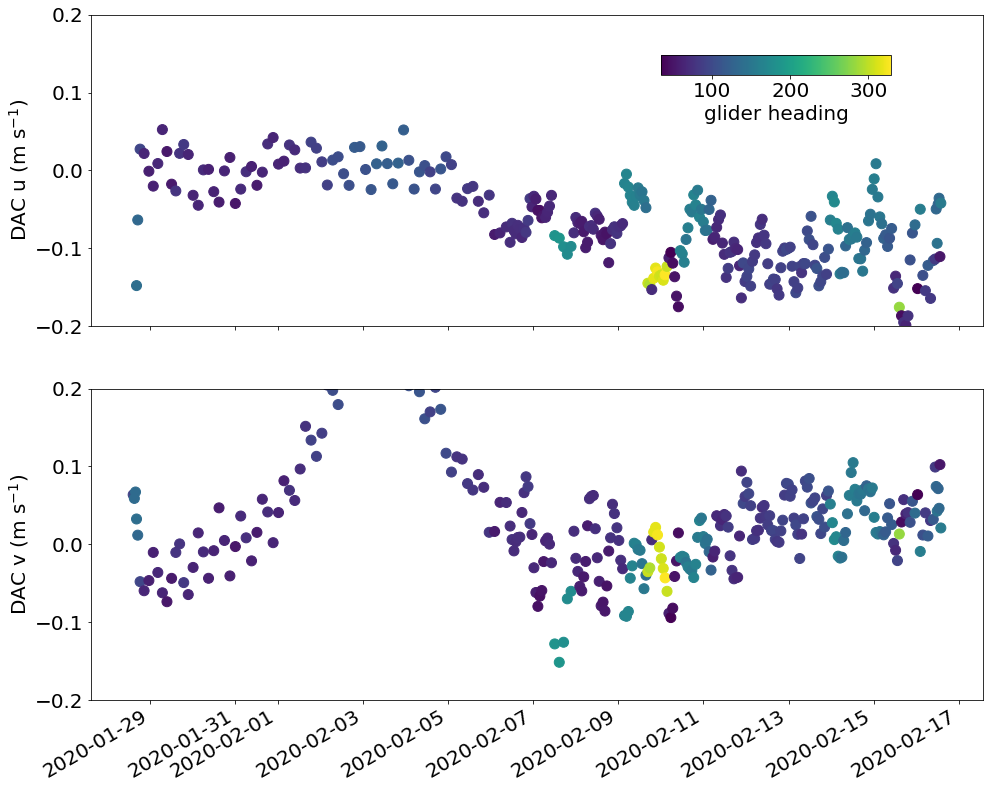

In [23]:
fig, ax = plt.subplots(2,1,figsize=(16,14), sharex=True)
ax = ax.ravel()
ax[0].scatter(glider_av_df.glider_time, glider_av_df.DAC_u, c=glider_av_df.heading)
scat = ax[1].scatter(glider_av_df.glider_time, glider_av_df.DAC_v, c=glider_av_df.heading)
fig.autofmt_xdate()

ax[0].set(ylabel='DAC u $(\mathrm{m\ s^{-1}})$', ylim=[-0.2, 0.2])
ax[1].set(ylabel='DAC v $(\mathrm{m\ s^{-1}})$', xlim = [glider_av_df.glider_time[0]- timedelta(days=1), glider_av_df.glider_time.iloc[-1]+ timedelta(days=1)], ylim=[-0.2, 0.2])
sub_ax = plt.axes([0.62, 0.82, 0.2, 0.02])
fig.colorbar(mappable=scat, orientation='horizontal',cax=sub_ax, label='glider heading')
savefig('DAC_by_dive_bearing')

Two patterns are apparent, the long term change in current speed and direction and a short term signal, more obvious in the u component, that shows a dependency on heading. This is a sign of a poorly calibrated compass

In [24]:
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(x, y)
    deg = (180/np.pi)*phi
    if deg<0:
        deg = 360+deg
    return(rho, deg)
cart2pol=np.vectorize(cart2pol)

In [25]:
glider_av_df['current_speed'], glider_av_df['current_bearing'] = cart2pol(glider_av_df.DAC_u, glider_av_df.DAC_v)

Plotting current speed and direction shows a switch around 5th February. There is nothing in the glider logs around this time. The compass calibration was performed on January 29.

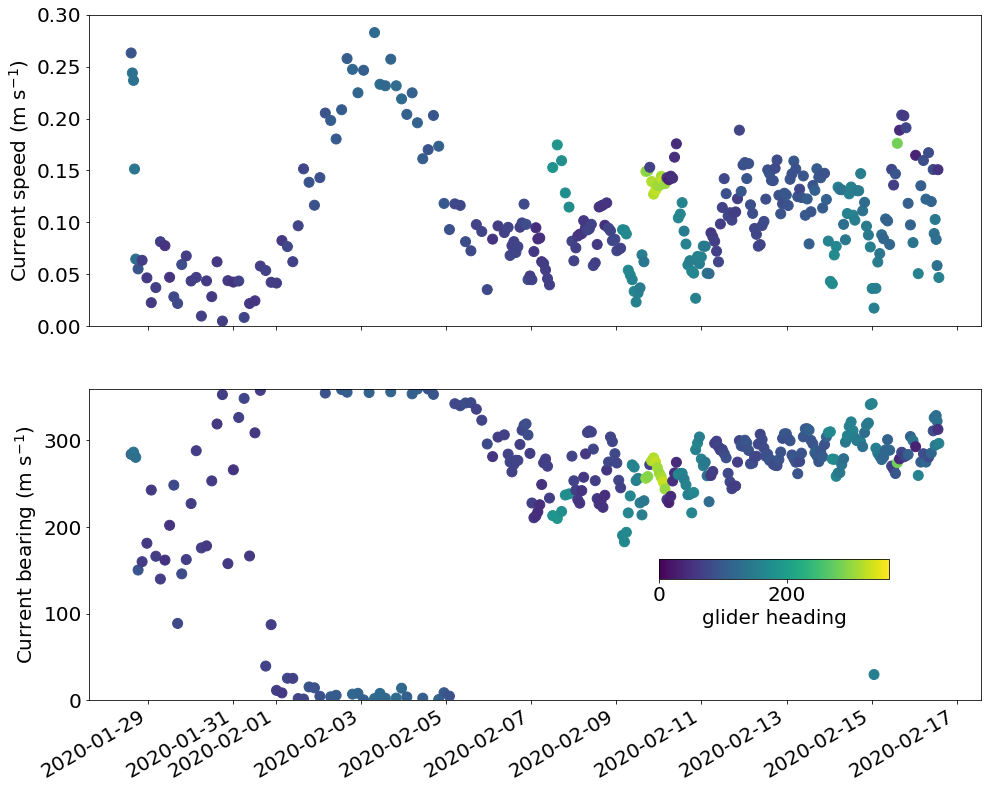

In [28]:
fig, ax = plt.subplots(2,1,figsize=(16,14), sharex=True)
ax = ax.ravel()
ax[0].scatter(glider_av_df.glider_time, glider_av_df.current_speed, c=glider_av_df.heading, vmin=0, vmax=360)
fig.autofmt_xdate()
scat = ax[1].scatter(glider_av_df.glider_time, glider_av_df.current_bearing, c=glider_av_df.heading, vmin=0, vmax=360)
ax[0].set(ylabel='Current speed $(\mathrm{m\ s^{-1}})$', ylim=[0, 0.3])
ax[1].set(ylabel='Current bearing $(\mathrm{m\ s^{-1}})$', xlim = [glider_av_df.glider_time[0]- timedelta(days=1), glider_av_df.glider_time.iloc[-1]+ timedelta(days=1)], ylim=[0,360])
sub_ax = plt.axes([0.62, 0.32, 0.2, 0.02])
fig.colorbar(mappable=scat, orientation='horizontal',cax=sub_ax, label='glider heading')
#savefig('current_heading')

In [ ]:
fig, ax = plt.subplots( figsize=(10,10))
ax.scatter(glider_df.abs_salinity, glider_df.temp, c=glider_df.glider_time, s = 1)
ax.set(xlabel='Absolute salinity', ylabel='Conserative temperature')
savefig('tempsal')


Make a new data frame, averaging in depth bins

In [ ]:
z_bin_size = 5
z_centers = np.arange(-800+z_bin_size/2, 0, z_bin_size)
z_centers
noot = []
for depth in glider_df.depth:
    noot.append(np.abs(z_centers+depth).argmin())
   
glider_df['depth_bin']= noot

In [ ]:
glider_z_av_df.abs_salinity.min()

In [ ]:
glider_z_av_df = glider_df.groupby('depth_bin', as_index=False).median()

In [ ]:
glider_df['sound_speed'] = gsw.sound_speed(glider_df.abs_salinity, glider_df.temp, glider_df.pressure)
fix_sal = np.empty((len(glider_z_av_df.index)))
fix_sal[:] = 35
sound_speed_adcp = gsw.sound_speed(fix_sal, glider_z_av_df.temp, glider_z_av_df.pressure)
fix_sal[:] = glider_z_av_df.abs_salinity.min()
sound_speed_min_sal = gsw.sound_speed(fix_sal, glider_z_av_df.temp, glider_z_av_df.pressure)
fix_sal[:] = glider_z_av_df.abs_salinity.max()
sound_speed_max_sal = gsw.sound_speed(fix_sal, glider_z_av_df.temp, glider_z_av_df.pressure)


In [ ]:
fig,ax = plt.subplots(figsize=(8,8))
ax.plot(glider_z_av_df.sound_speed, -glider_z_av_df.depth, label='From glider measurements')
ax.plot(sound_speed_adcp, -glider_z_av_df.depth, label='Used by ADCP')
#ax.plot(sound_speed_min_sal, -glider_z_av_df.depth, label='Calculted with minimum observed salinity')
#ax.plot(sound_speed_max_sal, -glider_z_av_df.depth, label='Calculted with maximum oberved salinity')
ax.set(xlabel='Speed of sound (m/s)', ylabel='z (m)', ylim=[-760, 0])
ax.legend()
savefig('speed_of_sound')

In [ ]:
glider_z_av_df['sound_speed_diff'] = np.abs(glider_z_av_df.sound_speed - sound_speed_adcp)
glider_z_av_df['sound_speed_diff'].describe()

### Difference between sound speed used by ADCP and observed in the water
Average difference of 0.9 m/s (0.06%) with a maximum difference of 2.9 m/s (0.2 %)

Taking these differnces as small realtive to the absolute values of sound speed observed and the accuracy of the ADCP, we consider this error in sound speed to be negligible

### importing the glider surfacings for drift calcualtion

In [ ]:
foo = scipy.io.loadmat('/media/callum/storage/Documents/foo/hero.mat')['proc_with_att']

In [ ]:
gps_post_pre_dive = scipy.io.loadmat('/media/callum/storage/Documents/foo/gpspostpredive.mat')['foo']
gps_post_dive = scipy.io.loadmat('/media/callum/storage/Documents/foo/gpspostdive.mat')['foo']
gps_pre_dive = scipy.io.loadmat('/media/callum/storage/Documents/foo/gpspredive.mat')['foo']

In [ ]:
gps_dives_df = pd.DataFrame({'lon_post_pre':gps_post_pre_dive[:,1], 'lat_post_pre':gps_post_pre_dive[:,0], 'time_post_pre':glidertimetoneat(gps_post_pre_dive[:,2])[1], 'lon_pre':gps_pre_dive[:,1], 'lat_pre':gps_pre_dive[:,0], 'time_pre':glidertimetoneat(gps_pre_dive[:,2])[1], 'lon_post':gps_post_dive[:,1], 'lat_post':gps_post_dive[:,0], 'time_post':glidertimetoneat(gps_post_dive[:,2])[1]}, index=None)

Calculate the drift time fro eac surfacing and, from that, the surface drift velocity

In [ ]:
time_drift = gps_dives_df_dt.time_pre - gps_dives_df_dt.time_post_pre
time_list = []
for time_point in time_drift:
    time_list.append(time_point.seconds)
gps_dives_df['drift_seconds'] = time_list

In [ ]:
gps_dives_df['drift_u'] = ((gps_dives_df.lon_pre-gps_dives_df.lon_post_pre)* deg_lat * np.cos(np.deg2rad(origin[1])))/gps_dives_df.drift_seconds
gps_dives_df['drift_v'] = ((gps_dives_df.lat_pre-gps_dives_df.lat_post_pre)* deg_lat)/gps_dives_df.drift_seconds

In [ ]:
gps_dives_df.describe()

In [ ]:
fig,ax = plt.subplots(2,1,sharex=True,figsize=(14,12))
ax = ax.ravel()
ax[0].scatter(gps_dives_df.time_post_pre,gps_dives_df.drift_u)
ax[1].scatter(gps_dives_df.time_post_pre, gps_dives_df.drift_v)
#ax[0].scatter(gps_dives_df.time_pre,gps_dives_df.lon_pre)
ax[0].set(xlim=[datetime(2020,1,23), datetime(2020,2,18)], ylim=[-0.5, 0.5],ylabel='Zonal drift speed (m/s)')
ax[1].set(ylim=[-0.5, 0.5],ylabel='Meridional drift speed (m/s)')
fig.autofmt_xdate()
savefig('surface_drift_speed')

In [ ]:
fig,ax = plt.subplots(2,1,sharex=True,figsize=(14,12))
ax = ax.ravel()
ax[0].scatter(gps_dives_df.time_post_pre,(gps_dives_df.lon_pre-gps_dives_df.lon_post_pre)* deg_lat * np.cos(np.deg2rad(origin[1])))
ax[1].scatter(gps_dives_df.time_post_pre,(gps_dives_df.lat_pre-gps_dives_df.lat_post_pre)* deg_lat)
#ax[0].scatter(gps_dives_df.time_pre,gps_dives_df.lon_pre)
ax[0].set(xlim=[datetime(2020,1,23), datetime(2020,2,18)], ylim=[-300, 300],ylabel='Zonal drift distance (m)')
ax[1].set(ylim=[-300, 300],ylabel='Meridional drift distance (m)')
fig.autofmt_xdate()
savefig('surface_drift_distance')

In [ ]:
fig,ax = plt.subplots(figsize=(14,12))
ax.quiver(gps_dives_df.lon_pre, gps_dives_df.lat_pre, gps_dives_df.drift_u, gps_dives_df.drift_v)
savefig('surface_drift_bowtie')